<a href="https://colab.research.google.com/github/OSedina/my-digit-model/blob/main/My_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
import numpy as np
import sklearn

import torch
import torchvision
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import random

import matplotlib.pyplot as plt
import time
import copy

import zipfile
import os
from PIL import Image

 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/digit.zip', 'r') as zip_obj:
  zip_obj.extractall('/content/gdrive/MyDrive/Colab Notebooks/')

In [ ]:
data_root = '/content/gdrive/MyDrive/Colab Notebooks/digit_1000'
print(os.listdir(data_root))

['test', 'train']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'


class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 100/100 [00:00<00:00, 511.80it/s]


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)


In [ ]:
len(train_dataloader), len(train_dataset)

(90, 900)

In [ ]:
len(val_dataloader), len(val_dataset)

(10, 100)

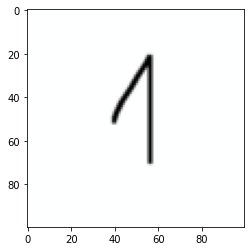

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

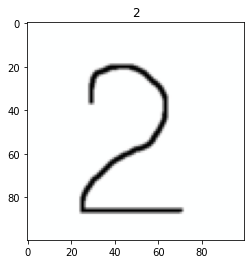

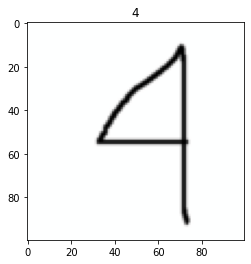

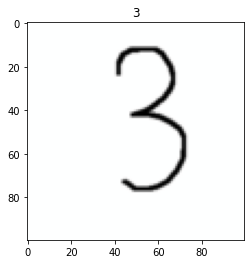

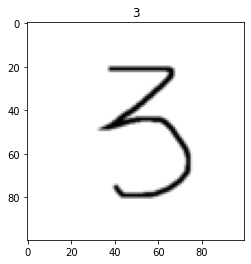

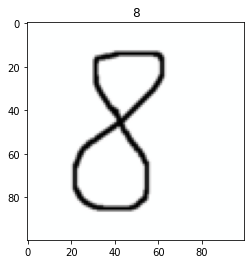

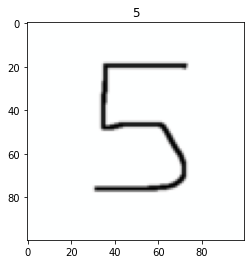

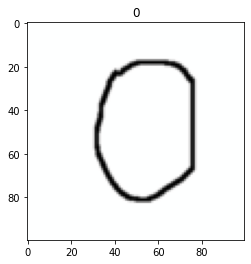

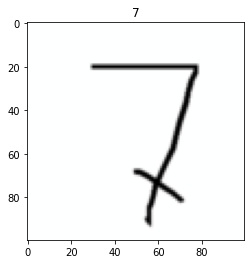

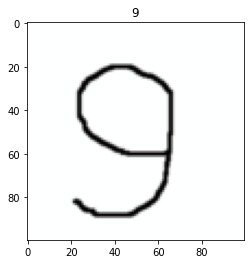

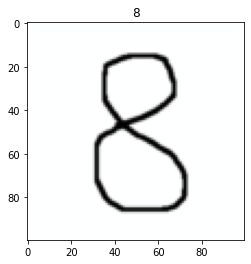

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
   
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                  dataloader = train_dataloader
                  scheduler.step()
                  model.train()  # Set model to training mode
            else:
                  dataloader = val_dataloader
                  model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

              # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  optimizer.zero_grad()

                  # forward and backward
                  with torch.set_grad_enabled(phase == 'train'):
                      preds = model(inputs)
                      loss_value = loss(preds, labels)
                      preds_class = preds.argmax(dim=1)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss_value.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss_value.item()
                  running_acc += (preds_class == labels.data).float().mean()
                  

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
              
            if (phase=='train'):
                  train_accuracy_history.append(epoch_acc)
                  train_loss_history.append(epoch_loss)
            elif (phase=='val'):
                  val_accuracy_history.append(epoch_acc)
                  val_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=20);

Epoch 0/19:


100%|██████████| 90/90 [00:07<00:00, 11.40it/s]

train Loss: 1.1258 Acc: 0.7022



100%|██████████| 10/10 [00:00<00:00, 12.44it/s]

val Loss: 0.3071 Acc: 0.9800
Epoch 1/19:



100%|██████████| 90/90 [00:02<00:00, 43.15it/s]

train Loss: 0.3664 Acc: 0.9278



100%|██████████| 10/10 [00:00<00:00, 12.52it/s]

val Loss: 0.1427 Acc: 0.9900
Epoch 2/19:



100%|██████████| 90/90 [00:02<00:00, 30.52it/s]

train Loss: 0.2570 Acc: 0.9511



100%|██████████| 10/10 [00:01<00:00,  9.10it/s]

val Loss: 0.1059 Acc: 0.9900
Epoch 3/19:



100%|██████████| 90/90 [00:02<00:00, 42.34it/s]

train Loss: 0.1712 Acc: 0.9678



100%|██████████| 10/10 [00:00<00:00, 11.52it/s]

val Loss: 0.0756 Acc: 1.0000
Epoch 4/19:



100%|██████████| 90/90 [00:02<00:00, 41.43it/s]

train Loss: 0.1846 Acc: 0.9544



100%|██████████| 10/10 [00:00<00:00, 11.27it/s]

val Loss: 0.0748 Acc: 0.9900
Epoch 5/19:



100%|██████████| 90/90 [00:02<00:00, 40.06it/s]

train Loss: 0.1385 Acc: 0.9722



100%|██████████| 10/10 [00:00<00:00, 11.01it/s]

val Loss: 0.0739 Acc: 0.9900
Epoch 6/19:



100%|██████████| 90/90 [00:02<00:00, 39.95it/s]

train Loss: 0.1320 Acc: 0.9811



100%|██████████| 10/10 [00:00<00:00, 12.27it/s]

val Loss: 0.0697 Acc: 1.0000
Epoch 7/19:



100%|██████████| 90/90 [00:02<00:00, 41.20it/s]

train Loss: 0.1280 Acc: 0.9767



100%|██████████| 10/10 [00:00<00:00, 11.39it/s]

val Loss: 0.0660 Acc: 0.9900
Epoch 8/19:



100%|██████████| 90/90 [00:02<00:00, 40.77it/s]

train Loss: 0.1283 Acc: 0.9822



100%|██████████| 10/10 [00:00<00:00, 12.01it/s]

val Loss: 0.0702 Acc: 0.9900
Epoch 9/19:



100%|██████████| 90/90 [00:02<00:00, 40.90it/s]

train Loss: 0.1282 Acc: 0.9833



100%|██████████| 10/10 [00:00<00:00, 11.76it/s]

val Loss: 0.0636 Acc: 1.0000
Epoch 10/19:



100%|██████████| 90/90 [00:02<00:00, 33.42it/s]

train Loss: 0.1410 Acc: 0.9744



100%|██████████| 10/10 [00:01<00:00,  8.70it/s]

val Loss: 0.0667 Acc: 1.0000
Epoch 11/19:



100%|██████████| 90/90 [00:02<00:00, 40.27it/s]

train Loss: 0.1115 Acc: 0.9856



100%|██████████| 10/10 [00:00<00:00, 11.94it/s]

val Loss: 0.0681 Acc: 1.0000
Epoch 12/19:



100%|██████████| 90/90 [00:02<00:00, 41.38it/s]

train Loss: 0.1225 Acc: 0.9789



100%|██████████| 10/10 [00:00<00:00, 12.10it/s]

val Loss: 0.0639 Acc: 1.0000
Epoch 13/19:



100%|██████████| 90/90 [00:02<00:00, 42.12it/s]

train Loss: 0.1188 Acc: 0.9800



100%|██████████| 10/10 [00:00<00:00, 11.99it/s]

val Loss: 0.0620 Acc: 1.0000
Epoch 14/19:



100%|██████████| 90/90 [00:02<00:00, 41.39it/s]

train Loss: 0.1182 Acc: 0.9856



100%|██████████| 10/10 [00:00<00:00, 12.24it/s]

val Loss: 0.0609 Acc: 1.0000
Epoch 15/19:



100%|██████████| 90/90 [00:02<00:00, 41.47it/s]

train Loss: 0.1250 Acc: 0.9767



100%|██████████| 10/10 [00:00<00:00, 12.05it/s]

val Loss: 0.0604 Acc: 1.0000
Epoch 16/19:



100%|██████████| 90/90 [00:02<00:00, 41.92it/s]

train Loss: 0.1335 Acc: 0.9800



100%|██████████| 10/10 [00:00<00:00, 12.13it/s]

val Loss: 0.0666 Acc: 0.9900
Epoch 17/19:



100%|██████████| 90/90 [00:02<00:00, 41.08it/s]

train Loss: 0.1218 Acc: 0.9856



100%|██████████| 10/10 [00:00<00:00, 12.07it/s]

val Loss: 0.0621 Acc: 0.9900
Epoch 18/19:



100%|██████████| 90/90 [00:02<00:00, 41.84it/s]

train Loss: 0.1321 Acc: 0.9744



100%|██████████| 10/10 [00:00<00:00, 12.28it/s]

val Loss: 0.0690 Acc: 1.0000
Epoch 19/19:



100%|██████████| 90/90 [00:02<00:00, 42.53it/s]

train Loss: 0.1210 Acc: 0.9844



100%|██████████| 10/10 [00:00<00:00, 12.13it/s]

val Loss: 0.0600 Acc: 1.0000


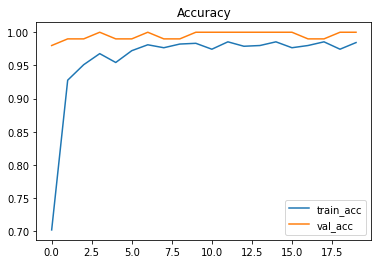

In [ ]:
list_acc_train = []
for i in train_accuracy_history:
  list_acc_train.append(i.item())
list_acc_val =[]
for j in val_accuracy_history:
  list_acc_val.append(j.item())

plt.plot(list_acc_train, label='train_acc')
plt.plot(list_acc_val, label='val_acc')
plt.legend()
plt.title('Accuracy');
  


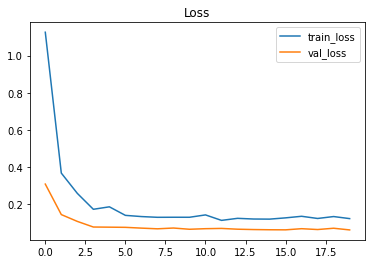

In [ ]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.title('Loss');

test_dataset

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 3
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
len(test_dataset), len(test_dataloader)

(3, 3)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        test_predictions.append(torch.nn.functional.softmax(preds).data.cpu())
        test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions, axis=0)


100%|██████████| 3/3 [00:00<00:00, 85.86it/s]


In [ ]:
test_predictions

array([[5.7431380e-03, 7.9934680e-06, 1.0920764e-03, 7.6294753e-05,
        6.8186296e-06, 2.8934315e-05, 9.6994202e-04, 9.7813165e-05,
        9.8855048e-01, 3.4264177e-03],
       [9.4353920e-04, 2.0091899e-02, 6.9257314e-03, 1.3469793e-03,
        9.5530766e-01, 1.5668933e-03, 2.1796667e-03, 1.0882112e-02,
        2.4576587e-04, 5.0986483e-04],
       [1.6380443e-01, 1.2809009e-03, 7.7943513e-03, 2.2427307e-03,
        1.4226817e-03, 5.9454204e-03, 7.1249610e-01, 1.9877696e-02,
        5.2207701e-02, 3.2928053e-02]], dtype=float32)

In [ ]:
out = []
for i in test_predictions:
  out_digit = np.argmax(i)
  out.append(out_digit)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': out})
submission_df

,id,label
0,test/unknown/cvbnmhgs6.png,8
1,test/unknown/jjkhtteedcch0.png,4
2,test/unknown/ppolkkwqw4.png,6


In [ ]:
answer = dict({'id': test_img_paths, 'label': out})

In [ ]:
answer

{'id': ['test/unknown/cvbnmhgs6.png',
  'test/unknown/jjkhtteedcch0.png',
  'test/unknown/ppolkkwqw4.png'],
 'label': [8, 4, 6]}

In [ ]:
states = {'epoch': 20,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()}

torch.save(states, '/content/gdrive/MyDrive/Colab Notebooks/model.pt')


In [ ]:
stats_dict = {'train_acc':list_acc_train, 'valid_acc':list_acc_val,
              'train_loss': train_loss_history, 'valid_loss': val_loss_history}

with open('stats.json', 'w') as f:
    json.dump(stats_dict, f)